In [ ]:
"""
Contexto

El objetivo es analizar el comportamiento de los usuarios para identificar
señales de intención comercial que puedan convertirse en features dentro del modelado.

- Propensión de compra
- Segmentación avanzada
- Pricing dinámico
- DaaP (insights)
- MMM

Este notebook NO entrena modelos.
Produce hipótesis y features candidatas.
"""

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set(style="whitegrid")


In [3]:
DATA_RAW = Path("../data/raw")

users = pd.read_csv(DATA_RAW / "users.csv")
events = pd.read_csv(DATA_RAW / "events.csv")
products = pd.read_csv(DATA_RAW / "products.csv")
transactions = pd.read_csv(DATA_RAW / "transaction_items.csv")


In [4]:
print("Users:", users.shape)
print("Events:", events.shape)
print("Products:", products.shape)
print("Transactions:", transactions.shape)


Users: (50000, 4)
Events: (500000, 6)
Products: (5000, 4)
Transactions: (120000, 4)


In [5]:
n_users = users["user_id"].nunique()
buyers = transactions["user_id"].nunique()

conversion_rate = buyers / n_users

conversion_rate


0.90806

In [6]:
user_event_counts = events.groupby("user_id").size()

user_event_counts.describe()


count    49996.000000
mean        10.000800
std          3.163068
min          1.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         23.000000
dtype: float64

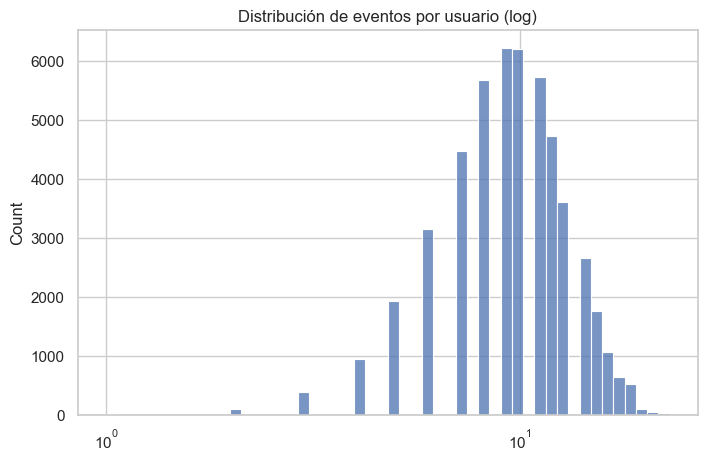

In [7]:
plt.figure(figsize=(8,5))
sns.histplot(user_event_counts, bins=50, log_scale=True)
plt.title("Distribución de eventos por usuario (log)")
plt.show()


In [8]:
buyers_flag = users[["user_id"]].copy()
buyers_flag["is_buyer"] = buyers_flag["user_id"].isin(transactions["user_id"])

buyers_flag["is_buyer"].value_counts(normalize=True)


is_buyer
True     0.90806
False    0.09194
Name: proportion, dtype: float64

In [9]:
events_per_user = user_event_counts.reset_index()
events_per_user.columns = ["user_id", "num_events"]

events_per_user = events_per_user.merge(
    buyers_flag, on="user_id", how="left"
)

events_per_user.groupby("is_buyer")["num_events"].mean()


is_buyer
False     9.991514
True     10.001740
Name: num_events, dtype: float64

In [12]:
events["event_timestamp"] = pd.to_datetime(events["timestamp"])

events_sorted = events.sort_values(["user_id", "event_timestamp"])

events_sorted["time_diff"] = events_sorted.groupby("user_id")[
    "event_timestamp"
].diff().dt.total_seconds()


In [11]:
events.columns

Index(['event_id', 'user_id', 'event_type', 'product_id', 'timestamp',
       'revenue'],
      dtype='object')

In [13]:
events_sorted["time_diff"].describe()


count    4.500040e+05
mean     2.802867e+06
std      2.761198e+06
min      0.000000e+00
25%      8.159400e+05
50%      1.959960e+06
75%      3.903720e+06
max      2.985984e+07
Name: time_diff, dtype: float64

In [15]:
transactions.columns

Index(['transaction_id', 'user_id', 'product_id', 'quantity'], dtype='object')

In [17]:
# Usuarios compradores sin dimensión de tiempo
buyers = set(transactions["user_id"])

events["is_buyer"] = events["user_id"].isin(buyers)

events.groupby("is_buyer").size()


is_buyer
False     45921
True     454079
dtype: int64

In [18]:
frequency = transactions.groupby("user_id").size()
monetary = (
    transactions
    .merge(products[["product_id", "price"]], on="product_id", how="left")
    .assign(total=lambda x: x["price"] * x["quantity"])
    .groupby("user_id")["total"]
    .sum()
)

rfm = pd.concat([frequency, monetary], axis=1)
rfm.columns = ["frequency", "monetary"]

rfm.head()


,frequency,monetary
user_id,,
1,2,2204.94
3,2,1878.15
4,2,1130.91
6,2,1782.75
7,2,1258.57


In [19]:
features_summary = [
    "num_events",
    "avg_time_between_events",
    "days_since_last_event",
    "num_events_pre_purchase",
    "purchase_frequency",
    "total_spend",
]

features_summary


['num_events',
 'avg_time_between_events',
 'days_since_last_event',
 'num_events_pre_purchase',
 'purchase_frequency',
 'total_spend']